## Q3 Gaussian Mixture Models

Importing libraries

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os
import seaborn as sns
from scipy.stats import norm

### Using Kmeans clustering method for smart initialisation 

In [ ]:
class KMeansClustering:
    def __init__(self, n_clusters, max_iterations=100, tolerance=1e-6):
        self.n_clusters = n_clusters
        self.centroids = None
        self.tolerance = tolerance
        self.max_iterations = max_iterations

    def _initialize_centroids(self, X):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        return X[indices]

    def _compute_distances(self, X):
        # Shape: (n_samples, n_clusters)
        distances = np.sqrt(((X[:, np.newaxis, :] - self.centroids) ** 2).sum(axis=2))
        return distances

    def fit(self, X):
        X = np.asarray(X)
        n_samples, n_features = X.shape

        # Initialize centroids
        self.centroids = self._initialize_centroids(X)

        for iteration in range(self.max_iterations):
            distances = self._compute_distances(X)
            cluster_assignments = np.argmin(distances, axis=1)

            updated_centroids = np.zeros((self.n_clusters, n_features))
            for idx in range(self.n_clusters):
                points_in_cluster = X[cluster_assignments == idx]
                if points_in_cluster.size == 0:
                    updated_centroids[idx] = X[np.random.choice(n_samples)]
                else:
                    updated_centroids[idx] = points_in_cluster.mean(axis=0)

            shift = np.linalg.norm(updated_centroids - self.centroids)
            self.centroids = updated_centroids

            if shift < self.tolerance:
                break

        return self.centroids


class GaussianMixtureModel:
    def __init__(self, n_components, max_iterations=100, tolerance=1e-6):
        self.n_components = n_components
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.means = None
        self.covariances = None
        self.weights = None
        self.responsibility_matrix = None

    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape

        kmeans = KMeansClustering(n_clusters=self.n_components)
        self.means = kmeans.fit(X)

        self.weights = np.full(self.n_components, 1 / self.n_components)
        self.covariances = np.array([np.cov(X, rowvar=False) + np.eye(n_features) * 1e-6
                                     for _ in range(self.n_components)])

    def _expectation_step(self, X):
        n_samples = X.shape[0]
        responsibility_matrix = np.zeros((n_samples, self.n_components))

        for idx in range(self.n_components):
            try:
                pdf_values = multivariate_normal(mean=self.means[idx],
                                                 cov=self.covariances[idx]).pdf(X)
            except np.linalg.LinAlgError:
                reg_cov = self.covariances[idx] + np.eye(X.shape[1]) * 1e-4
                pdf_values = multivariate_normal(mean=self.means[idx],
                                                 cov=reg_cov).pdf(X)

            responsibility_matrix[:, idx] = self.weights[idx] * pdf_values

        total_responsibility = responsibility_matrix.sum(axis=1, keepdims=True)
        total_responsibility[total_responsibility == 0] = 1e-10
        responsibility_matrix /= total_responsibility

        return responsibility_matrix

    def _maximization_step(self, X, responsibilities):
        n_samples, n_features = X.shape
        Nk = responsibilities.sum(axis=0)

        self.weights = Nk / n_samples
        self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]

        for idx in range(self.n_components):
            diff = X - self.means[idx]
            weighted_sum = np.dot((responsibilities[:, idx][:, np.newaxis] * diff).T, diff)
            self.covariances[idx] = weighted_sum / Nk[idx] + np.eye(n_features) * 1e-6

    def fit(self, X):
        X = np.asarray(X)
        self._initialize_parameters(X)

        prev_log_likelihood = -np.inf

        for iteration in range(self.max_iterations):
            responsibilities = self._expectation_step(X)
            self._maximization_step(X, responsibilities)
            self.responsibility_matrix = responsibilities

            # Compute log-likelihood
            log_likelihood = 0.0
            for idx in range(self.n_components):
                try:
                    pdf_values = multivariate_normal(mean=self.means[idx],
                                                     cov=self.covariances[idx]).pdf(X)
                except np.linalg.LinAlgError:
                    reg_cov = self.covariances[idx] + np.eye(X.shape[1]) * 1e-4
                    pdf_values = multivariate_normal(mean=self.means[idx],
                                                     cov=reg_cov).pdf(X)

                log_likelihood += np.sum(self.weights[idx] * pdf_values)

            if np.abs(log_likelihood - prev_log_likelihood) < self.tolerance:
                break

            prev_log_likelihood = log_likelihood

        return self

    def predict(self, X):
        if self.responsibility_matrix is None:
            raise ValueError("Model has not been fitted yet.")
        return np.argmax(self.responsibility_matrix, axis=1)


In [ ]:

# --- Helper Functions --- #
def load_nifti(file_path):
    nii_obj = nib.load(file_path)
    return nii_obj.get_fdata(), nii_obj.affine


def save_segmentation(segmentation_data, affine, filename):
    seg_img = nib.Nifti1Image(segmentation_data, affine, dtype=np.uint8)
    nib.save(seg_img, filename)


def compute_accuracy(pred_seg, true_seg, mask, label_id):
    """
    Computes tissue-specific accuracy within the brain mask.
    """
    pred = (pred_seg[mask] == label_id)
    truth = (true_seg[mask] == label_id)
    overlap = np.logical_and(pred, truth)
    if np.sum(truth) == 0:
        return 0.0
    return np.sum(overlap) / np.sum(truth)


# --- Load Data --- #
img_file = "sald_031764_img.nii"
gm_prob_file = 'sald_031764_probmask_graymatter.nii'
wm_prob_file = 'sald_031764_probmask_whitematter.nii'
csf_prob_file = 'sald_031764_probmask_csf.nii'

image_data, affine = load_nifti(img_file)
gm_prob, _ = load_nifti(gm_prob_file)
wm_prob, _ = load_nifti(wm_prob_file)
csf_prob, _ = load_nifti(csf_prob_file)

# --- Prepare True Segmentation --- #
probabilities = np.stack([csf_prob, gm_prob, wm_prob], axis=-1)
true_segmentation = np.argmax(probabilities, axis=-1) + 1

# --- Brain Mask and Feature Extraction --- #
brain_mask = image_data > 0
voxel_intensities = image_data[brain_mask].reshape(-1, 1)

# --- Gaussian Mixture Model --- #
gmm_model = GaussianMixtureModel(n_components=3, max_iter=100, tol=1e-6)
gmm_model.fit(voxel_intensities)
predicted_clusters = gmm_model.predict(voxel_intensities)

# --- Map Cluster Labels to Tissue Types --- #
cluster_means = gmm_model.means.flatten()
sorted_cluster_indices = np.argsort(cluster_means)

# Create tissue mapping (1=CSF, 2=GM, 3=WM)
cluster_to_tissue = np.zeros(3, dtype=int)
cluster_to_tissue[sorted_cluster_indices[0]] = 1  # CSF
cluster_to_tissue[sorted_cluster_indices[1]] = 2  # GM
cluster_to_tissue[sorted_cluster_indices[2]] = 3  # WM

# Assign tissue labels to voxels
tissue_segmentation = np.zeros_like(image_data, dtype=int)
tissue_segmentation[brain_mask] = cluster_to_tissue[predicted_clusters]

# --- Save Segmentation --- #
output_seg_file = "gmm_segmentation.nii"
save_segmentation(tissue_segmentation, affine, output_seg_file)

# --- Accuracy Calculations --- #
overall_accuracy = np.sum(
    tissue_segmentation[brain_mask] == true_segmentation[brain_mask]
) / np.sum(brain_mask)

tissue_names = ['CSF', 'GM', 'WM']
tissue_metrics = {}

for idx, tissue in enumerate(tissue_names):
    acc = compute_accuracy(
        tissue_segmentation, true_segmentation, brain_mask, label_id=idx + 1
    )
    tissue_metrics[tissue] = {'accuracy': acc}

# --- Print Results --- #
print(f"\nOverall pointwise accuracy: {overall_accuracy * 100:.4f}%")

for tissue, stats in tissue_metrics.items():
    print(f"{tissue} - Accuracy: {stats['accuracy'] * 100:.4f}%")



Overall pointwise accuracy: 80.0602
CSF - Accuracy: 83.7727
GM - Accuracy: 99.9871
WM - Accuracy: 51.2922


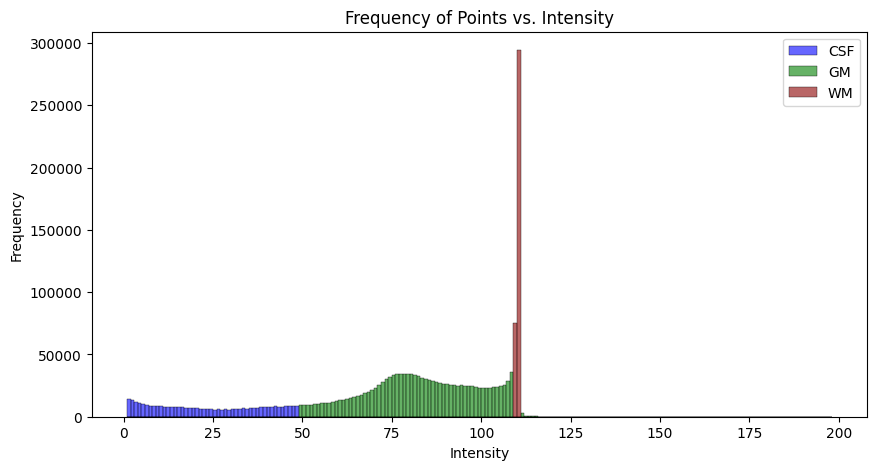

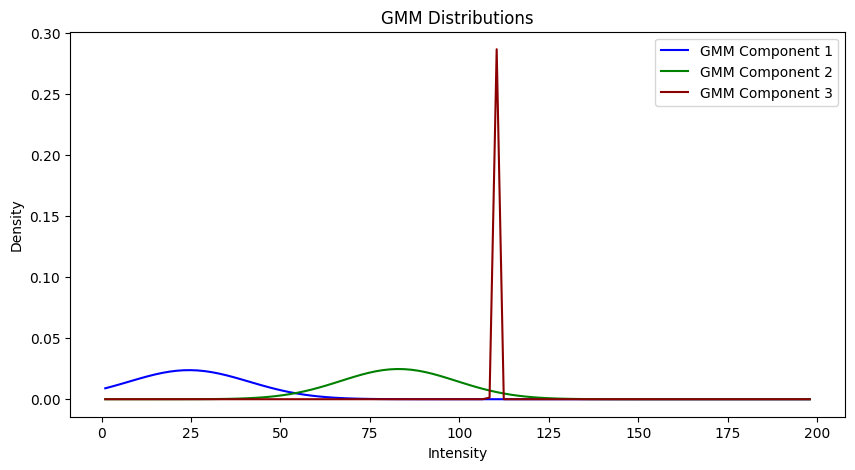

In [ ]:
def plot_intensity_histograms(intensities, labels, tissue_names, colors, bin_width=1):
    """
    Plots histograms of voxel intensities for each tissue type.
    """
    bins = np.arange(intensities.min(), intensities.max() + bin_width, bin_width)

    plt.figure(figsize=(12, 6))
    for idx, tissue in enumerate(tissue_names):
        tissue_mask = (labels == (idx + 1))
        sns.histplot(
            intensities[tissue_mask],
            bins=bins,
            color=colors[idx],
            label=tissue,
            kde=False,
            alpha=0.6,
        )

    plt.xlabel('Voxel Intensity')
    plt.ylabel('Frequency')
    plt.title('Voxel Intensity Distribution by Tissue Type')
    plt.legend(title='Tissue')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_gmm_components(intensities, gmm, tissue_names, colors, num_points=200):
    """
    Plots the GMM component probability density functions over intensity values.
    """
    x_range = np.linspace(intensities.min(), intensities.max(), num_points)

    plt.figure(figsize=(12, 6))
    for idx, (mean, cov) in enumerate(zip(gmm.means.flatten(), gmm.covs.flatten())):
        std_dev = np.sqrt(cov)
        pdf = norm.pdf(x_range, loc=mean, scale=std_dev)

        plt.plot(
            x_range,
            pdf,
            color=colors[idx],
            linewidth=2,
            label=f'{tissue_names[idx]} (mean={mean:.1f}, std={std_dev:.1f})'
        )

    plt.xlabel('Voxel Intensity')
    plt.ylabel('Density')
    plt.title('GMM Component Distributions')
    plt.legend(title='Tissue Type')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# --- Data Preparation --- #
# Flatten the brain voxel intensities and labels
voxel_intensities = brain_voxels.flatten()
voxel_labels = tissue_labels.flatten()

# Define colors and tissue names
tissue_colors = ['blue', 'green', 'darkred']
tissue_types = ['CSF', 'GM', 'WM']

# --- Plotting --- #
plot_intensity_histograms(
    intensities=voxel_intensities,
    labels=voxel_labels,
    tissue_names=tissue_types,
    colors=tissue_colors,
    bin_width=1
)

plot_gmm_components(
    intensities=voxel_intensities,
    gmm=GaussianMixtureModel,
    tissue_names=tissue_types,
    colors=tissue_colors,
    num_points=300
)


Misclassification Analysis
Insights from the Plots
1. Intensity Distribution Histogram

    This plot illustrates how voxel intensities are distributed across the three tissue types: CSF, GM, and WM.
    CSF primarily exhibits low-intensity values, GM spans a mid-range intensity, while WM shows a distinct and sharp peak close to an intensity of 100.

2. GMM Component Curves

    The second plot displays the probability density functions of the Gaussian components estimated by the GMM.
    The WM component has a very narrow distribution with a sharp peak, indicating minimal variance.
    In contrast, the GM and CSF distributions are broader, reflecting greater variability in their intensity values.

- Areas with the Most Misclassification

    - The most frequent misclassifications occur between GM and WM.
    This happens because the WM component is highly concentrated around an intensity of 100, while GM has a wider range of intensities, causing overlaps in the intensity values of GM and WM.
    As a result, GM voxels with intensities near 100 are often mistaken for WM, particularly due to the very small variance in the WM component.
    Although there is some potential confusion between CSF and GM, the difference in their intensity ranges makes it less common compared to GM and WM overlap.

- Underlying Causes of Misclassification

    - Assumption of Gaussian Distributions in GMM
    The GMM model relies on the assumption that each tissue type follows a Gaussian distribution, which may not accurately capture the true intensity distribution of brain tissues.

    - WM's Dominance Due to Its Sharp Peak
    The narrow, high peak of WM intensities around 100 suggests that WM dominates its cluster, potentially absorbing nearby GM voxels into its classification.

    - Overlapping Intensity Ranges
    GM's broader distribution causes it to spill into the intensity region dominated by WM, leading to misclassification where their distributions overlap.

### Using ITK-SNAP software for medical imaging , after putting sald_031764_img.nii brain MRI image and its segmentation image named gmm_segmention.nii , I obtain the below segmentation for axial, coronal and saggital view

### Original Axial view and After Segmentation View

![Alt Text](Q3_files/original_axial.png)
![Alt Text](Q3_files/axial.png)


### Original Coronal view and After Segmentation View


![Alt Text](Q3_files/original_coronal.png)
![Alt Text](Q3_files/coronal.png)


### Original Sagittal view and After Segmentation View


![Alt Text](Q3_files/original_sagittal.png)
![Alt Text](Q3_files/sagittal.png)
